# Hometask 5

Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ

Обучить модель на выбор из segmentation_models_pytorch

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [2]:
# !unzip /content/data/archive.zip

Изучим, что есть в list.csv

In [3]:
DATA_PATH = '/content/set-lipstick-original/'

In [4]:
df = pd.read_csv(DATA_PATH + 'list.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [5]:
df.describe()

,width,height,xmin,ymin,xmax,ymax
count,28594.0,28594.000000,28594.000000,28594.000000,28594.00000,28594.000000
mean,1280.0,718.663881,598.519445,301.300273,704.45632,362.676016
std,0.0,7.638207,84.979569,84.473834,88.29236,96.020078
min,1280.0,675.000000,170.000000,22.000000,280.00000,98.000000
25%,1280.0,720.000000,578.000000,242.000000,672.00000,295.000000
50%,1280.0,720.000000,601.000000,294.000000,691.00000,356.000000
75%,1280.0,720.000000,630.000000,356.000000,724.00000,419.000000
max,1280.0,720.000000,1036.000000,577.000000,1082.00000,650.000000


In [6]:
df.count()

filename    28594
width       28594
height      28594
class       28594
xmin        28594
ymin        28594
xmax        28594
ymax        28594
mask        28594
dtype: int64

Посмотрим, как выглядят файлы с изображением и маской

(-0.5, 1279.5, 719.5, -0.5)

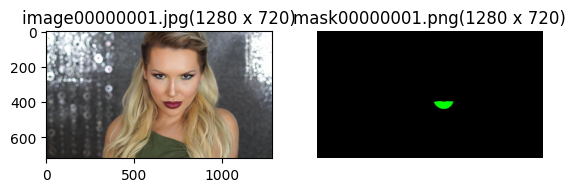

In [7]:
plt.subplot(1, 2, 1)
plt.title(df['filename'][0] + '({} x {})'.format(df['width'][0], df['height'][0]))
img = plt.imread(DATA_PATH + '720p/' + df['filename'][0])
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title(df['mask'][0] + '({} x {})'.format(df['width'][0], df['height'][0]))
img = plt.imread(DATA_PATH + 'mask/' + df['mask'][0])
plt.imshow(img)

plt.axis('off')

Реализация пользовательского класса.

In [8]:
class LipsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        
        # Separate images
        self.image_arr = self.data['filename']
        # Separate masks
        self.label_arr = self.data['mask']
        
        # Count
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        # Read image
        img = cv2.cvtColor(cv2.imread(DATA_PATH + '720p/' + self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Normalizing [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        # Read mask
        mask = cv2.cvtColor(cv2.imread(DATA_PATH + 'mask/' + self.label_arr[index]), cv2.COLOR_BGR2RGB)
        cls_mask = mask[:, :, 1]
        cls_mask = np.where(mask > 10, 1, 0)[:, :, 1]
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))

        masks = [cls_mask]
            
        masks = torch.as_tensor(masks, dtype=torch.uint8)    
        
            
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

На всякий случай проверим, что все есть.

In [9]:
list_images = sorted([i for i in Path(DATA_PATH + '720p').iterdir()])
list_masks = sorted([i for i in Path(DATA_PATH + 'mask').iterdir()])
len(list_images), len(list_masks)

(28594, 28540)

Внесём корректировки

In [10]:
df = df.loc[df['mask'].isin([i.name for i in list_masks])]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   width     28540 non-null  int64 
 2   height    28540 non-null  int64 
 3   class     28540 non-null  object
 4   xmin      28540 non-null  int64 
 5   ymin      28540 non-null  int64 
 6   xmax      28540 non-null  int64 
 7   ymax      28540 non-null  int64 
 8   mask      28540 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.0+ MB


Возьмём cuda если такое устройство доступно

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Инициализируем Linknet с предобученным энкодером resnet50:

In [12]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import segmentation_models_pytorch as smp

# создание модели
BACKBONE = 'resnet50'
segmodel = smp.Unet(BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Создадим датасет

<ipython-input-8-33f1af1ac7a5>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


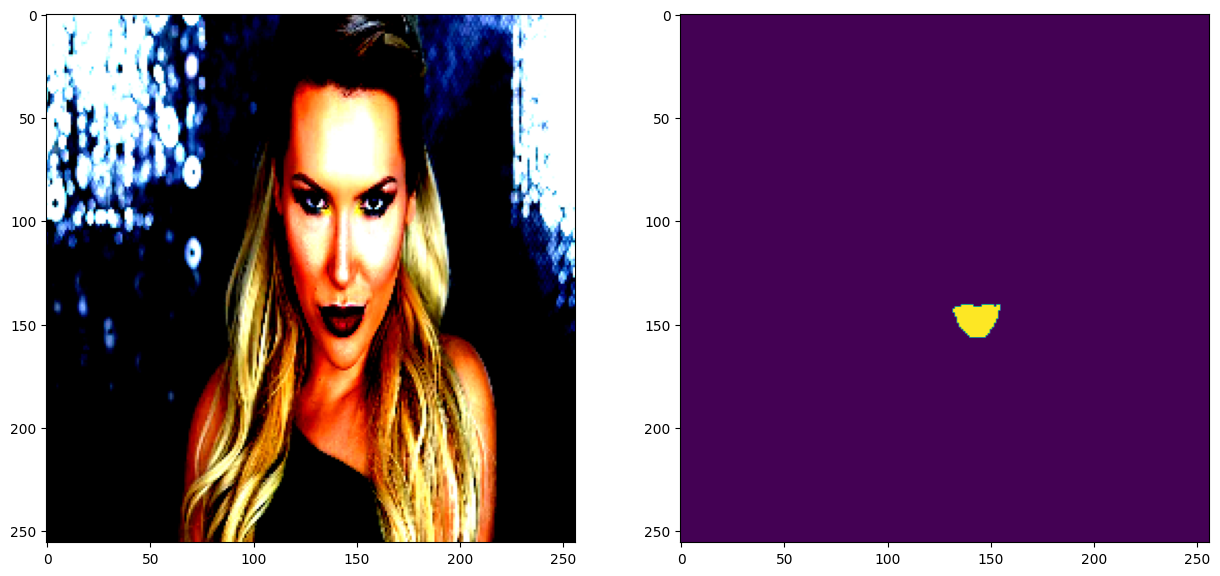

In [14]:
dataset = LipsDataset(df, preprocessing=preprocess_input)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[:, :, 0])
plt.show()

Подготовим выборку

In [15]:
X_train, X_test = train_test_split(df, test_size=0.25)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = LipsDataset(X_train)
test_data = LipsDataset(X_test)

Подготовим лоадеры

In [16]:
train_loader = DataLoader(
    train_data,
    batch_size=128,
    shuffle=True
)
test_loader = DataLoader(
    test_data,
    batch_size=64,
    shuffle=False
)

In [17]:
data_iter = iter(train_loader)
img, target = next(data_iter)
print(img.shape, target.shape)
print(img[0].min(), img[0].max())
print(target[0].min(), target[0].max())

torch.Size([128, 3, 256, 256]) torch.Size([128, 1, 256, 256])
tensor(0.) tensor(1.)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


Последний тенхор от 0 до 1 - то что надо.

In [18]:
print(segmodel)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

Обучать всю модель не надо, поэтому поставим флаг, чтобы веса не обучались.

In [19]:
for param in list(segmodel.encoder.parameters())[:]:
    param.requires_grad = False

In [20]:
summary(segmodel.to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

Довольно большое количество параметров для обучения. Посмотрим, как справится cuda

In [21]:
from segmentation_models_pytorch import utils

In [22]:
criterion = utils.losses.DiceLoss()
metrics = [utils.metrics.IoU()]

params_to_update = []
for name, param in segmodel.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [23]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

Попробуем несколько эпох

In [24]:
# train model

max_score = 999999999

for i in range(3):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(test_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 112/112 [05:03<00:00,  2.71s/it, dice_loss - 0.05342, iou_score - 0.9213]
Epoch: 2
valid: 100%|██████████| 112/112 [04:58<00:00,  2.66s/it, dice_loss - 0.03741, iou_score - 0.9365]
Epoch: 3
valid: 100%|██████████| 112/112 [04:58<00:00,  2.66s/it, dice_loss - 0.03005, iou_score - 0.9467]


In [25]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

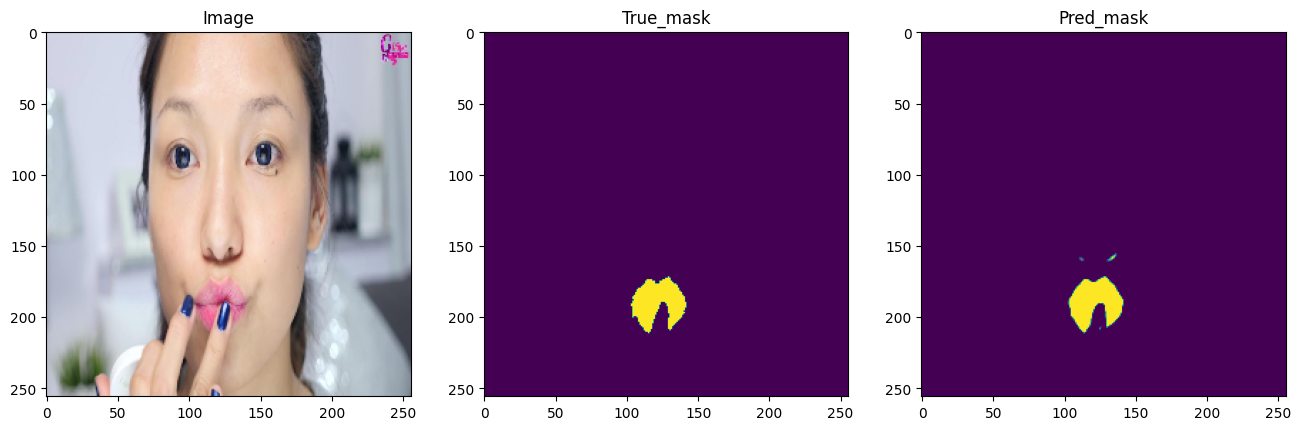

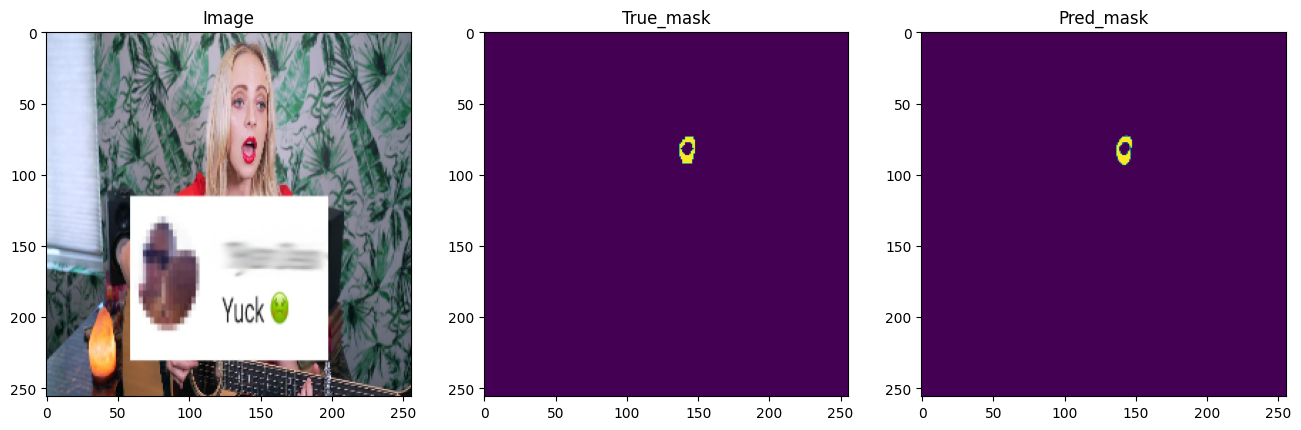

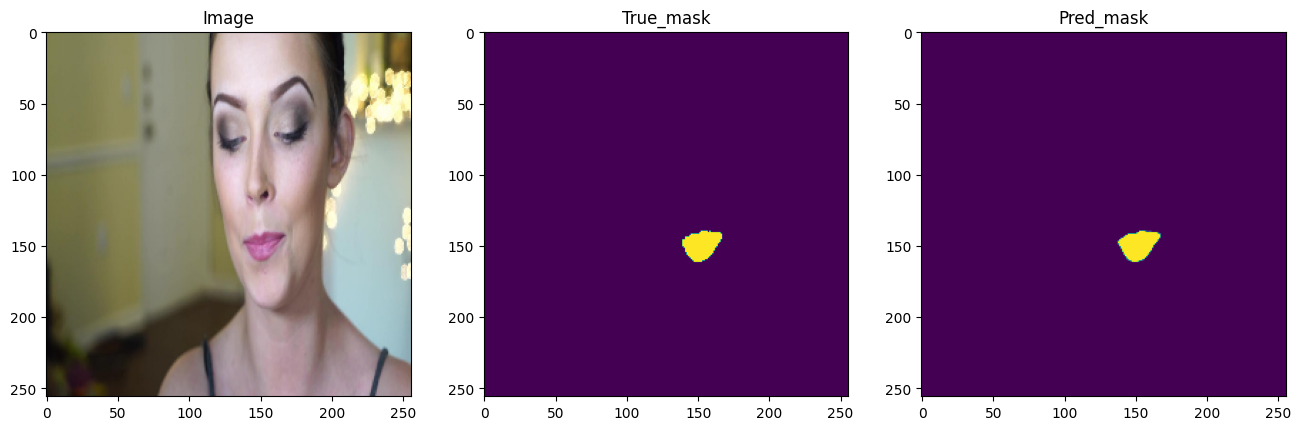

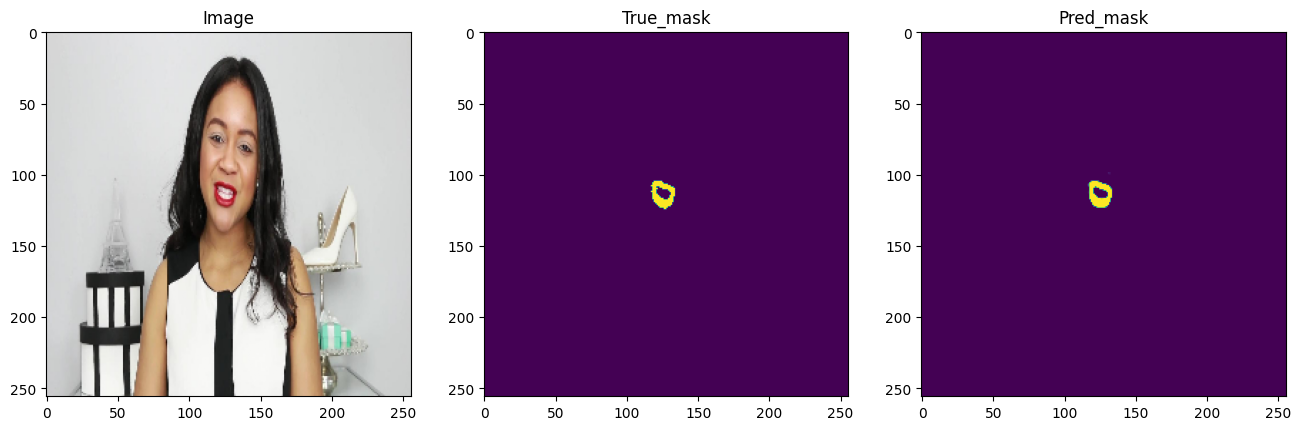

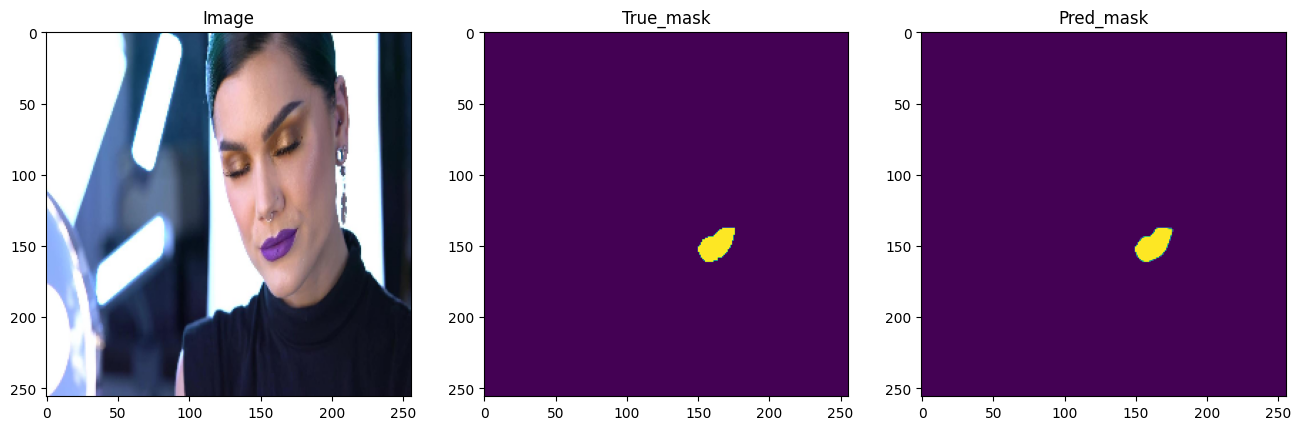

In [26]:
for i in range(5):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0)[:, :, 0])
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0)[:, :, 0])
    ax_3.set_title('Pred_mask')

Три итерации и большая предобученная сеть resnet50 показали очень хорошие результаты. Скорость обучения не слишком быстрая, но преемлемая.